In [38]:
import cv2
import dlib
import numpy as np
import os
from scipy.spatial import distance
from imutils import face_utils
from tqdm import tqdm

# Function to calculate eye aspect ratio (EAR)

def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

In [57]:

# Load face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")

# Indices of facial landmarks for left and right eyes
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

# Function to calculate eye aspect ratio
def eye_aspect_ratio(eye):
    eye = np.array(eye)
    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])
    C = np.linalg.norm(eye[0] - eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

# Function to process frames
def process_frame(frame, frame_count, output_dir):
    
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Noise reduction using bilateral filter
    blurred = cv2.bilateralFilter(gray, 9, 75, 75)
    
    # Histogram equalization for enhancing contrast
    equalized = cv2.equalizeHist(gray)
    
    # Edge detection using Canny
    # edges = cv2.Canny(gray, 100, 20)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    edges = cv2.sqrt(cv2.addWeighted(cv2.pow(sobelx, 2), 1.0, cv2.pow(sobely, 2), 1.0, 0))
    edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    
    # Morphology techniques (Closing operation to close gaps between edges)
    kernel = np.ones((5,5),np.uint8)
    closing = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    
    # improve contrast using open cv scal abs
    contrasted = cv2.convertScaleAbs(gray, alpha=1.5, beta=0)
    
    # Eye detection using dlib
    subjects = detector(equalized, 0)
    leftEye = []
    rightEye = []
    for subject in subjects:
        shape = predictor(equalized, subject)
        shape = [(shape.part(i).x, shape.part(i).y) for i in range(68)]
        
        # Extract left and right eye landmarks
        leftEye = shape[lStart:lEnd]
        rightEye = shape[rStart:rEnd]

        # Calculate eye aspect ratio if both left and right eyes are detected
        if len(leftEye) == 6 and len(rightEye) == 6:
            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)
            
            # Average EAR of both eyes
            ear = (leftEAR + rightEAR) / 2.0
        else:
            ear = 0.0
    
    # Save processed frames into respective directories
    cv2.imwrite(os.path.join(output_dir, 'original', f'frame-{frame_count}.jpg'), frame)
    cv2.imwrite(os.path.join(output_dir, 'sobel', f'frame-{frame_count}.jpg'), edges)
    cv2.imwrite(os.path.join(output_dir, 'grey', f'frame-{frame_count}.jpg'), gray)
    cv2.imwrite(os.path.join(output_dir, 'morphology', f'frame-{frame_count}.jpg'), closing)
    cv2.imwrite(os.path.join(output_dir, 'noise_reduction', f'frame-{frame_count}.jpg'), blurred)
    cv2.imwrite(os.path.join(output_dir, 'hist_equilization', f'frame-{frame_count}.jpg'), equalized)
    cv2.imwrite(os.path.join(output_dir, 'contrast_improv', f'frame-{frame_count}.jpg'), contrasted)
    
    return equalized

# Create output directories if they don't exist
output_dir = 'output'
os.makedirs(os.path.join(output_dir, 'original'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'sobel'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'grey'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'morphology'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'noise_reduction'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'hist_equilization'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'contrast_improv'), exist_ok=True)

# Open the video file
cap = cv2.VideoCapture('videos/video3.MOV')

# Initialize variables
frame_count = 0
fps = cap.get(cv2.CAP_PROP_FPS)
interval = int(fps) * 1  # Extract frame every 1 second

# Process frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_count += 1
    
    if frame_count % interval == 0:
        processed_frame = process_frame(frame, frame_count, output_dir)
        cv2.imshow('Processed Frame', processed_frame)
        
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [50]:
import cv2
import numpy as np

# Load the image
image = cv2.imread(r'output\original\frame-87.jpg')

# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define range of eye color in HSV
lower_eye_color = np.array([0, 50, 50])
upper_eye_color = np.array([30, 255, 255])

# Threshold the HSV image to get only eye color
mask = cv2.inRange(hsv_image, lower_eye_color, upper_eye_color)

# Bitwise-AND mask and original image
segmented_image = cv2.bitwise_and(image, image, mask=mask)

# Display the segmented image

# change the size of the window output
cv2.namedWindow('Segmented Eyes', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Segmented Eyes', 1080, 720)
cv2.imshow('Segmented Eyes', segmented_image)
# cv2.imshow('Segmented Eyes', segmented_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


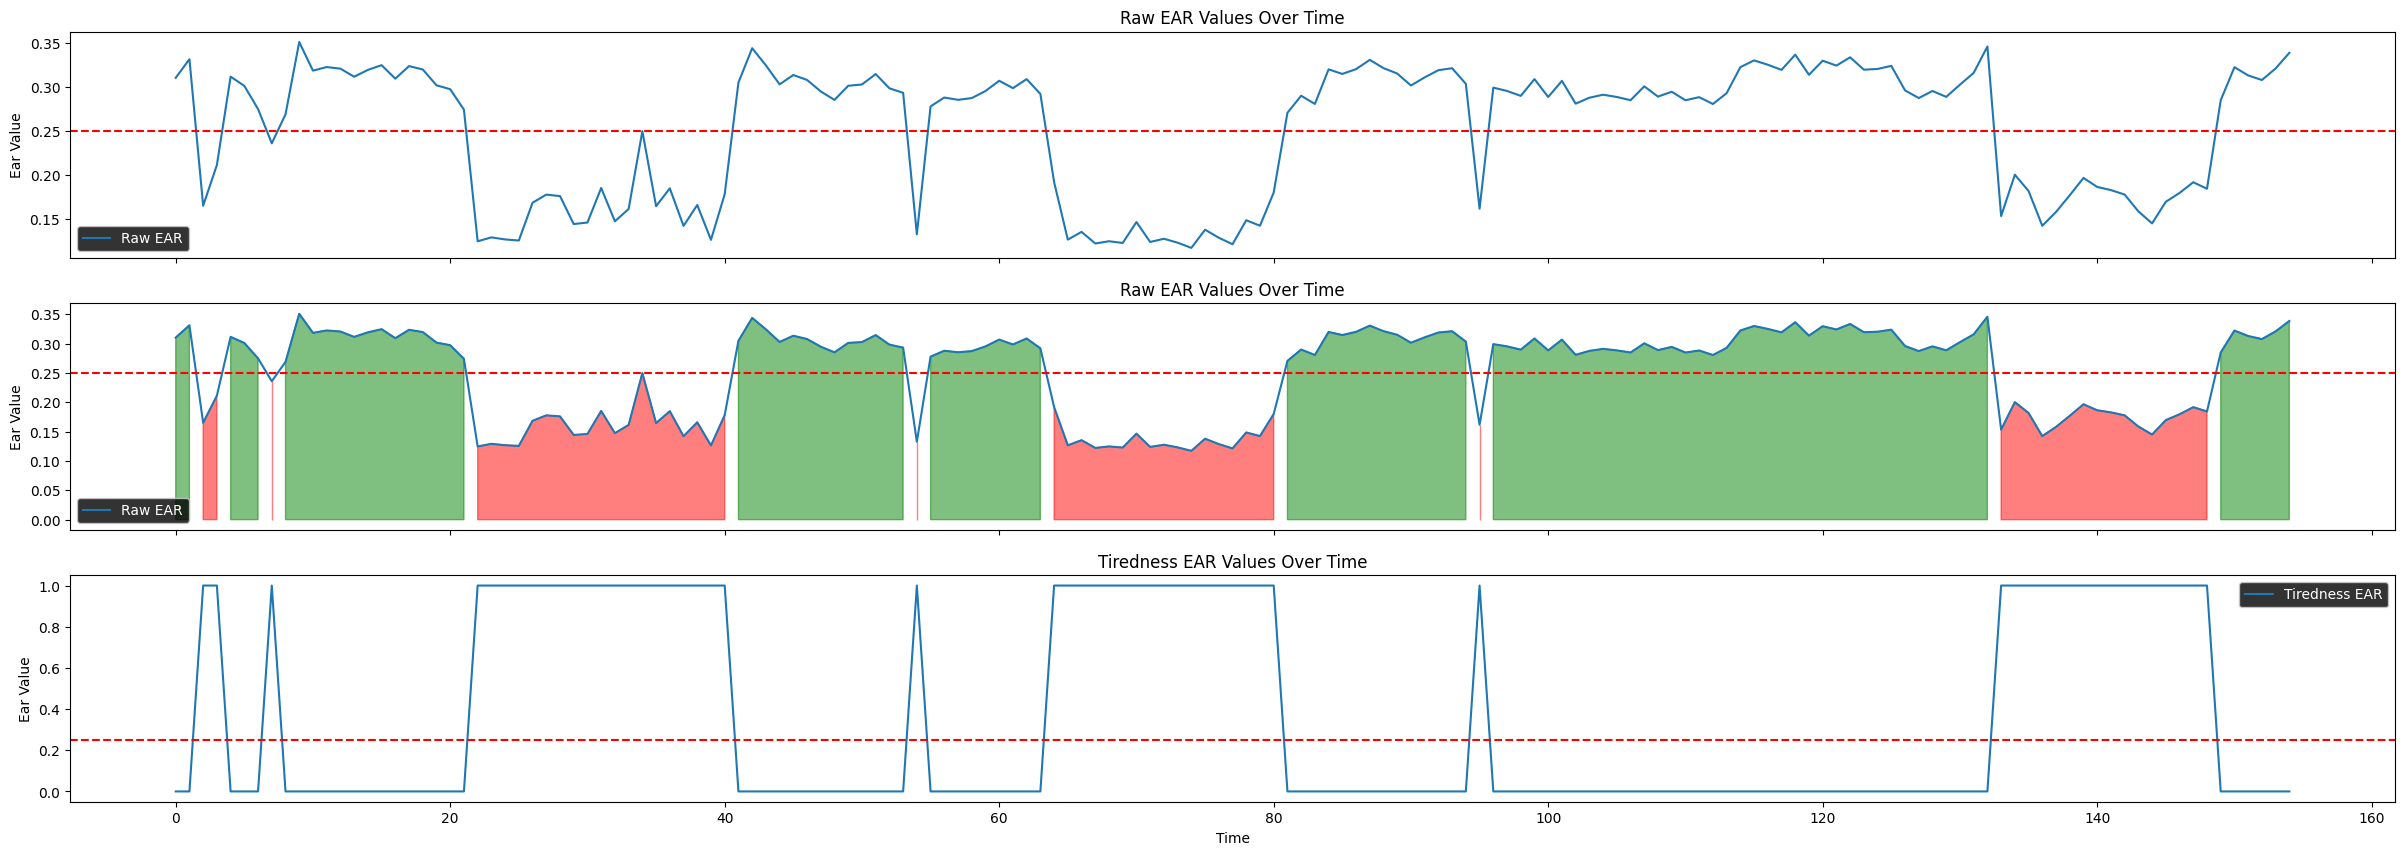

In [2]:

import cv2
import dlib
import numpy as np
import os
from scipy.spatial import distance
from imutils import face_utils
import pygame
from threading import Thread
from datetime import datetime
import csv
import matplotlib.pyplot as plt
import pandas as pd

# Initialize pygame mixer for playing audio and Load the alert sound
pygame.mixer.init()
alert_sound = pygame.mixer.Sound("audio/wake_up.wav")
danger_image = cv2.imread("assets/danger.png")

# Function to calculate eye aspect ratio (EAR)
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear
                
def save_ear_values(ear_values, frame_count, threshold=0.25):
    if ear_values:
        if frame_count % 10 == 0:
            timestamp = datetime.now().strftime("%M:%S:%f")
            with open('output/ear_values.csv', mode='a', newline='\n') as file:
                writer = csv.writer(file)
                if file.tell() == 0:
                    writer.writerow(['time', 'EAR'])
                for ear in ear_values:  # Iterate over all EAR values
                    writer.writerow([timestamp, ear])  # Save each EAR value with the timestamp
            
            with open('output/tiredness.csv', mode='a', newline='\n') as tiredness_file:
                tiredness_writer = csv.writer(tiredness_file)
                if tiredness_file.tell() == 0:
                    tiredness_writer.writerow(['time', 'EAR'])
                
                for ear in ear_values:  # Iterate over all EAR values
                    if ear < threshold:  # Check if the EAR value is below the threshold
                        tiredness_writer.writerow([timestamp, 1])  # Save the EAR value if below the threshold
                    else:
                        tiredness_writer.writerow([timestamp, 0])

def plot_ear_values(ear_df:pd.DataFrame, tire_df:pd.DataFrame) -> None:
    """
    Plot the EAR values over time.

    Args:
        ear_df (pd.DataFrame): DataFrame containing the raw EAR values.
        tire_df (pd.DataFrame): DataFrame containing the tiredness EAR values.
    """
    # Create subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30, 10), sharex=True)
    plt.style.use('dark_background')

    # Plot raw EAR values
    ax1.plot(range(len(ear_df['EAR'])), ear_df['EAR'], label='Raw EAR')
    ax1.set_ylabel("Ear Value")
    ax1.set_title("Raw EAR Values Over Time")
    ax1.axhline(y=0.25, color='r', linestyle='--')
    ax1.legend()

    # Plot raw EAR values with color fill
    ax2.plot(range(len(ear_df['EAR'])), ear_df['EAR'], label='Raw EAR')
    ax2.fill_between(range(len(ear_df['EAR'])), ear_df['EAR'], where=ear_df['EAR'] < 0.25, color='red', alpha=0.5)
    ax2.fill_between(range(len(ear_df['EAR'])), ear_df['EAR'], where=ear_df['EAR'] >= 0.25, color='green', alpha=0.5)
    ax2.set_ylabel("Ear Value")
    ax2.set_title("Raw EAR Values Over Time")
    ax2.axhline(y=0.25, color='r', linestyle='--')
    ax2.legend()

    # Plot tiredness EAR values
    ax3.plot(range(len(tire_df['EAR'])), tire_df['EAR'], label='Tiredness EAR')
    ax3.set_xlabel("Time")
    ax3.set_ylabel("Ear Value")
    ax3.set_title("Tiredness EAR Values Over Time")
    ax3.axhline(y=0.25, color='r', linestyle='--')
    ax3.legend()

    # Display the subplots
    plt.show()

# Initialize variables
ear_values = []
frame_count = 0
frame_count_2 = 0
alert_count = 0
exit_flag = False

# Load face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")

# Indices of facial landmarks for left and right eyes
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]


# Function to process frames
def process_frame(frame, frame_count, output_dir):
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Noise reduction using bilateral filter
    blurred = cv2.bilateralFilter(gray, 9, 75, 75)
    
    # Histogram equalization for enhancing contrast
    equalized = cv2.equalizeHist(gray)
    
    # Edge detection using Sobel
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    edges = cv2.sqrt(cv2.addWeighted(cv2.pow(sobelx, 2), 1.0, cv2.pow(sobely, 2), 1.0, 0))
    edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    
    # Morphology techniques (Closing operation to close gaps between edges)
    kernel = np.ones((5,5),np.uint8)
    closing = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    
    # Improve contrast using OpenCV convertScaleAbs
    contrasted = cv2.convertScaleAbs(gray, alpha=1.5, beta=0)
    
    # Save processed frames into respective directories
    cv2.imwrite(os.path.join(output_dir, 'original', f'frame-{frame_count}.jpg'), frame)
    cv2.imwrite(os.path.join(output_dir, 'sobel', f'frame-{frame_count}.jpg'), edges)
    cv2.imwrite(os.path.join(output_dir, 'grey', f'frame-{frame_count}.jpg'), gray)
    cv2.imwrite(os.path.join(output_dir, 'morphology', f'frame-{frame_count}.jpg'), closing)
    cv2.imwrite(os.path.join(output_dir, 'noise_reduction', f'frame-{frame_count}.jpg'), blurred)
    cv2.imwrite(os.path.join(output_dir, 'hist_equilization', f'frame-{frame_count}.jpg'), equalized)
    cv2.imwrite(os.path.join(output_dir, 'contrast_improv', f'frame-{frame_count}.jpg'), contrasted)
    
    return gray

# Create output directories if they don't exist
output_dir = 'output'
os.makedirs(os.path.join(output_dir, 'original'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'sobel'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'grey'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'morphology'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'noise_reduction'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'hist_equilization'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'contrast_improv'), exist_ok=True)

# Open the video file
cap = cv2.VideoCapture(0)

width = 1080
cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Initialize variables
fps = cap.get(cv2.CAP_PROP_FPS)
interval = int(fps) * 1  # Extract frame every 1 second

# Function to process frames and save processed frames every 1 second
def process_frames_and_save():
    global frame_count, exit_flag  # Declare frame_count and exit_flag as global
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or exit_flag:  # Exit loop if not ret or exit_flag is True
            break
        
        frame_count += 1
        
        if frame_count % interval == 0:
            processed_frame = process_frame(frame, frame_count, output_dir)
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            exit_flag = True  # Set exit_flag to True if 'q' is pressed
            break

# Start a thread for processing frames and saving processed frames
processing_thread = Thread(target=process_frames_and_save)
processing_thread.start()

# Start detecting tiredness
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocessing: Convert to grayscale, detect faces
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    subjects = detector(gray, 0)

    # Loop over detected faces
    for subject in subjects:
        # Detect facial landmarks
        shape = predictor(gray, subject)
        shape = face_utils.shape_to_np(shape)

        # Extract left and right eye coordinates
        leftEye = shape[lStart:lEnd]
        rightEye = shape[rStart:rEnd]

        # Calculate EAR for each eye
        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye)

        # Average EAR of both eyes
        ear = (leftEAR + rightEAR) / 2.0
        ear_values.append(ear)
        
        # Draw eyes contours
        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
        cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 255), 1)  # Yellow color
        cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 255), 1)  # Yellow color

        # Draw eyes on the frame
        for (x, y) in leftEye:
            cv2.circle(frame, (x, y), 2, (0, 0, 255), -1)
        for (x, y) in rightEye:
            cv2.circle(frame, (x, y), 2, (0, 0, 255), -1)

        # Connect landmarks with lines
        cv2.line(frame, tuple(leftEye[1]), tuple(leftEye[5]), (0, 255, 0), 1)
        cv2.line(frame, tuple(leftEye[2]), tuple(leftEye[4]), (0, 255, 0), 1)
        cv2.line(frame, tuple(leftEye[0]), tuple(leftEye[3]), (0, 255, 0), 1)
        cv2.line(frame, tuple(rightEye[1]), tuple(rightEye[5]), (0, 255, 0), 1)
        cv2.line(frame, tuple(rightEye[2]), tuple(rightEye[4]), (0, 255, 0), 1)
        cv2.line(frame, tuple(rightEye[0]), tuple(rightEye[3]), (0, 255, 0), 1)

        # Check if eyes are closed
        if ear < 0.25:
            alert_count += 1
            if alert_count >= 10 and not pygame.mixer.get_busy():
                # Visual alert (draw text)
                cv2.putText(frame, "ALERT! Fatigue Detected !!!", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 4)
                cv2.putText(frame, "ALERT! Fatigue Detected !!!", (frame.shape[1] - 550, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 4)

                # Display danger image on both sides
                frame[50:50 + danger_image.shape[0], 50:50 + danger_image.shape[1]] = danger_image
                frame[50:50 + danger_image.shape[0], frame.shape[1] - 50 - danger_image.shape[1]:frame.shape[1] - 50] = danger_image

                # Play sound alert
                alert_sound.play()

        else:
            alert_count = 0

    # Display the frame (if needed)
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        exit_flag = True
        break

    # Increment frame count
    frame_count_2 += 1
    
    # Check if it's time to save EAR values to CSV
    if frame_count_2 % 10 == 0:  # Save EAR values every 10 frames
        save_ear_values(ear_values, frame_count_2)
        ear_values = []  # Clear the ear_values list
        
# Wait for the processing thread to finish
processing_thread.join()

# Release resources
cap.release()
cv2.destroyAllWindows()

ear_df = pd.read_csv('output/ear_values.csv')
tire_df = pd.read_csv('output/tiredness.csv')

plot_ear_values(ear_df, tire_df)



In [11]:
import cv2
import dlib

# Load the pre-trained facial landmark detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")

# Load the input image
image = cv2.imread("pictures/face.png")

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the grayscale image
faces = detector(gray)

# Iterate over each detected face
for face in faces:
    # Predict facial landmarks for the detected face
    landmarks = predictor(gray, face)
    landmarks = [(p.x, p.y) for p in landmarks.parts()]

    # Draw circles at each landmark point
    for i, landmark in enumerate(landmarks, start=1):
        cv2.circle(image, landmark, 5, (0, 255, 0), -1)  # Red color
        cv2.putText(image, str(i), landmark, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)  # Green color

    # Connect landmarks with lines
    # for i in range(1, len(landmarks)):
    #     cv2.line(image, landmarks[i - 1], landmarks[i], (255, 0, 0), 1)  # Blue color

# Save the image with landmarks
cv2.imwrite("output_image.jpg", image)


True